Time: 6.378073453903198
Planet orbit 
Planet 1 SMJ axis in AU 1.0004445354801939
Planet 1 eccentricity 0.016259466556556763
Planet 2 SMJ axis in AU 0.1849015885108695
Planet 2 eccentricity 0.9853405180606826


C:\Users\guygj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\guygj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


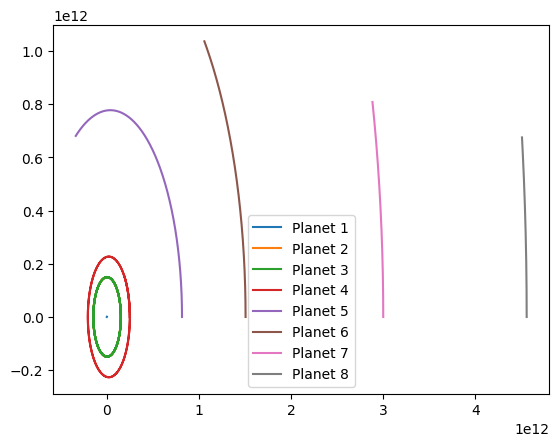

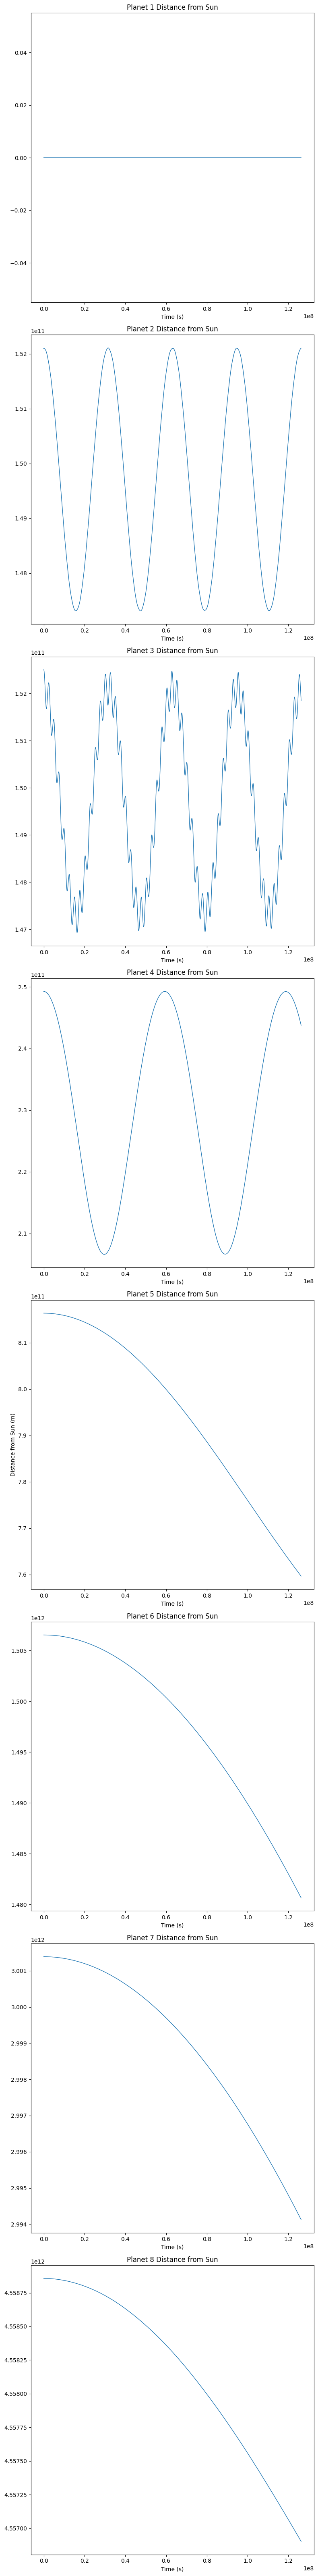

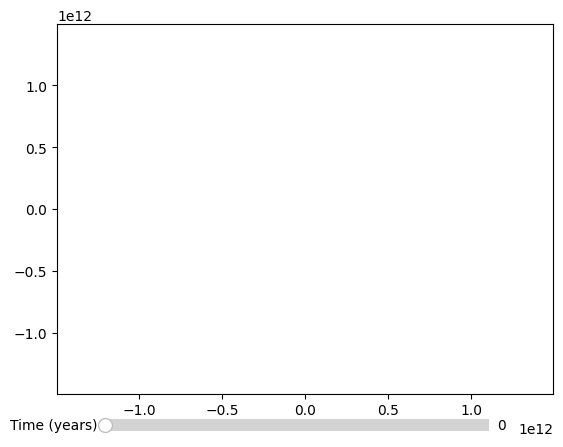

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from matplotlib.widgets import Slider
from scipy.signal import find_peaks

# Fundamental constants
G = 6.6743e-11  # gravitational constant
yr = 24*60*60*365.25  # year in seconds
AU = 1.496e11  # one AU in meters

while True:
    T = input("Do you want to define own masses, velocities (Y or N): ").lower()
    if T.startswith('n'):
        # Masses (Kg)
        Ms = 1.9885e30  # sun
        Me = 5.9722e24  # earth
        Mm = 6.4169e23  # mars
        Mmo = 7.346e22  # moon
        Mj = 1.89813e27  # jupiter
        Msa = 5.6832e26  # saturn
        Mu = 8.6811e25  # uranus
        Mn = 1.0249e26  # neptune

        # Velocities (m/s)
        e_ap_v = 29290  # known earth velocity at aphelion
        mo_ap_v = 970  # known moon velocity rel earth at aphelion
        m_ap_v = 21970  # known mars velocity at aphelion
        j_ap_v = 12440  # known jupiter velocity at aphelion
        sa_ap_v = 9140  # known saturn velocity rel earth at aphelion
        u_ap_v = 6490  # known uranus velocity at aphelion
        n_ap_v = 5370  # known neptune velocity at aphelion

        # Aphelions (m)
        Earthx = 152.1e9
        Moony = 0.4055e9
        Marsx = 249.261e9
        Jupiterx = 816.363e9
        Saturnx = 1506.527e9
        Uranusx = 3001.390e9
        Neptunex = 4558.857e9

        r0 = np.array([[0, 0], [Earthx, 0], [Earthx+Moony, 0], [Marsx, 0], [Jupiterx, 0], [Saturnx, 0], [Uranusx, 0], [Neptunex, 0]])
        v0 = np.array([[0, 0], [0, e_ap_v], [0, mo_ap_v+e_ap_v], [0, m_ap_v], [0, j_ap_v], [0, sa_ap_v], [0, u_ap_v], [0, n_ap_v]])
        m = np.array([Ms, Me, Mmo, Mm, Mj, Msa, Mu, Mn])  # masses of the planets
        n = len(m)  # number of planets
        break

    elif T.startswith('y'):  # Manual input code
        n = int(input("Enter the number of planets: "))
        r0 = np.zeros((n, 2))
        v0 = np.zeros((n, 2))
        m = np.zeros(n)
        for i in range(n):
            m[i] = float(input(f"Enter the mass of planet {i+1} in kg: "))
            (x, y) = input(f"Enter the initial position of planet {i+1} in AU (x,y): ").split(",")
            (vx, vy) = input(f"Enter the initial velocity of planet {i+1} in m/s (vx,vy): ").split(",")
            r0[i] = np.array([float(x) * AU, float(y) * AU])
            v0[i] = np.array([float(vx), float(vy)])
        break
    else:
        print("You made an invalid choice, try again")

l = int(input("Enter the duration of the sim in years: "))

# Define time step size and duration of simulation
h = 60*60*24  # time step size
t0 = 0  # initial time
tf = l*yr  # final time (1 year)

# Get the start time
st = time.time()  # for run time of different integration methods

# Acceleration function Cowell's method
def acceleration(r):
    a = np.zeros_like(r)
    for i in range(n):
        for j in range(n):
            if i != j:  # ensure no 2 of same planet
                a[i] += G * m[j] * (r[j] - r[i]) / np.linalg.norm(r[j] - r[i])**3
    return a

# Data arrays
r = r0
v = v0
t = t0
r0 = []
pos_data = [r]
time_data = [t]
dist_data = [np.zeros(n)]
for i in range(n):  # Distance to object 1 at t = 0
    dist_data[0][i] = np.linalg.norm(r[i] - r[0])

T = input("Do you want to use Euler or Runge-Kutta: ").lower()

if T.startswith('r'):
    # Runge-Kutta method
    while t < tf:
        # Calculate acceleration
        a1 = acceleration(r)

        # First estimate of acceleration
        r_mid1 = r + 0.5 * h * v
        v_mid1 = v + 0.5 * h * a1
        a2 = acceleration(r_mid1)

        # Second estimate of acceleration
        r_mid2 = r + 0.5 * h * v_mid1
        v_mid2 = v + 0.5 * h * a2
        a3 = acceleration(r_mid2)

        # Third estimate of acceleration
        r_end = r + h * v_mid2
        v_end = v + h * a3
        a4 = acceleration(r_end)

        # Combination
        r_new = r + h * (v + 2*v_mid1 + 2*v_mid2 + v_end) / 6
        v_new = v + h * (a1 + 2*a2 + 2*a3 + a4) / 6

        # Update
        r = r_new
        v = v_new
        t += h

        # Arrays
        pos_data.append(r)
        time_data.append(t)

        # Distance from object 1
        dists = np.zeros(n)
        for i in range(n):
            dists[i] = np.linalg.norm(r[i] - r[0])
        dist_data.append(dists)

elif T.startswith('e'):
    # Euler method
    while t < tf:
        # Calculate acceleration
        a = acceleration(r)

        # New
        r_new = r + h * v
        v_new = v + h * a

        # Update
        r = r_new
        v = v_new
        t += h

        # Arrays
        pos_data.append(r)
        time_data.append(t)

        # Distance from object 1
        dists = np.zeros(n)
        for i in range(n):
            dists[i] = np.linalg.norm(r[i] - r[0])
        dist_data.append(dists)

# Convert to array
pos_data = np.array(pos_data)

# Get the end time
et = time.time()

# Elapsed time
elapsed_time = et - st
print('Time:', elapsed_time)

# Plot orbits
for i in range(n):
    plt.plot(pos_data[:, i, 0], pos_data[:, i, 1], label=f'Planet {i+1}')
plt.legend()

# Plot the distances from the object 1
dist_data = np.array(dist_data)
fig, axs = plt.subplots(n, 1, figsize=(8, 8*n))
for i in range(n):
    axs[i].plot(time_data, dist_data[:, i], linewidth=1)
    axs[i].set_xlabel('Time (s)')
    axs[i].set_title(f'Planet {i+1} Distance from Sun')
axs[int(n/2)].set_ylabel('Distance from Sun (m)')
plt.tight_layout()

turns = []
differences = []
average = []

for i in range(1, n):
    # Find peaks (maxima)
    peaks, _ = find_peaks(dist_data[:, i])
    turning_points = (peaks) * h / (60*60*24)
    turns.append(turning_points)

# Calculate differences between turning points
for elem in turns:
    diffs = []
    for i in range(len(elem) - 1):
        diff = elem[i + 1] - elem[i]
        diffs.append(diff)
    differences.append(diffs)

# Save data to a text file
file = open("sample.txt", "w+")
if len(diffs) > 1:
    data = str(diffs[0])
    file.write(data)
file.close()

# Displaying the contents of the text file
file = open("sample.txt", "r")
data = file.read()
print('Planet orbit', data)
file.close()

# Calculate and print the average orbital periods
for arr in differences:  # Loop over each array
    avg = np.mean(arr)  # Compute the average
    average.append(avg)  # Append the average

plandist = [Earthx, Moony, Marsx, Jupiterx, Saturnx, Uranusx, Neptunex]
for i in range(n - 1):
    if len(differences[i]) > 1:
        T = average[i]
        k = (G * Ms) / (4 * np.pi**2)
        SMJ = np.cbrt(k * (T * (yr / 365.25))**2)
        print(f'Planet {i + 1} SMJ axis in AU', SMJ / AU)
        e = abs(SMJ - plandist[i]) / SMJ
        print(f'Planet {i + 1} eccentricity', e)

# Create figure and axis for animation
fig, ax = plt.subplots()

# Set axis limits
ax.set_xlim(-10*AU, 10*AU)
ax.set_ylim(-10*AU, 10*AU)

# Creating empty plot to be updated during animation
line, = ax.plot([], [], 'o')

# Define function to update plot during animation
def update(frame):
    # Update data for plot
    line.set_data(pos_data[frame][:, 0], pos_data[frame][:, 1])
    # Set title for plot
    ax.set_title(f'Time = {time_data[frame] / yr:.2f} years')
    return line,

# Slider axis
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.05], facecolor='lightgray')

# Slider
slider = Slider(ax_slider, 'Time (years)', 0, len(pos_data) - 1, valinit=0, valstep=1)

# Function to update plot based on slider value
def update_slider(val):
    if val % 1 == 0:
        # Update data for plot
        line.set_data(pos_data[val][:, 0], pos_data[val][:, 1])
        # Set title for plot
        ax.set_title(f'Time = {time_data[val] / yr:.2f} years')
        # Plot the orbital paths of the planets
        for i in range(n):
            if val % 2 == 0:
                ax.plot(pos_data[:val, i, 0], pos_data[:val, i, 1], label=f'Planet {i + 1}', color=f'C{i}', alpha=0.5)
        # Set legend for orbital paths
        ax.legend(loc='upper left')
        # Removing duplicate labels
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

# Connect slider to update function
slider.on_changed(update_slider)
fig.canvas.draw_idle()

# Animating
ani = FuncAnimation(fig, update_slider, frames=len(pos_data), interval=1, cache_frame_data=True)
plt.show()

# Pause and play buttons
pause_button_ax = fig.add_axes([0.65, 0.15, 0.1, 0.075])
pause_button = plt.Button(pause_button_ax, 'Pause', hovercolor='0.975')
play_button_ax = fig.add_axes([0.75, 0.15, 0.1, 0.075])
play_button = plt.Button(play_button_ax, 'Play', hovercolor='0.975')

# Button clicks
def on_pause_button_clicked(event):
    ani.event_source.stop()

def on_play_button_clicked(event):
    ani.event_source.start()

# Connecting
pause_button.on_clicked(on_pause_button_clicked)
play_button.on_clicked(on_play_button_clicked)

# Show animation
plt.show()
